## Задание 3

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR

При этом метод сам по себе очень прост. Что это за метрика такая?

Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  
Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже). Как по мне, это ОЧЕНЬ круто.

**Задача:**

1) Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
2) Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [3]:
# Подгружаем библиотеки и подключаемся к БД
import pandas as pd
import pandahouse
import hashlib
import seaborn as sns
from scipy import stats

connection = {
            'host': 'https://clickhouse.lab.karpov.courses',
            'database':'simulator_20230220',
            'user':'student', 
            'password':'dpo_python_2020'
}


In [4]:
# Создаем dataframe
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2023-01-31' and toDate(time) <= '2023-02-06' 
    and exp_group in (0,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection = connection)

df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,48,135,0.355556
1,3,10326,19,65,0.292308
2,3,123580,22,109,0.201835
3,3,36785,44,272,0.161765
4,3,2709,20,92,0.217391


<AxesSubplot:xlabel='ctr', ylabel='Count'>

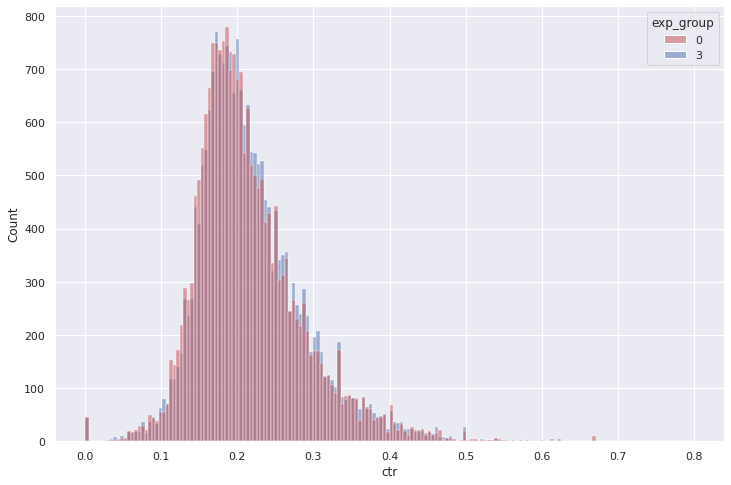

In [38]:
# Построим распредление гурпп 0 и 3
sns.set(rc={'figure.figsize': [12.0, 8.0]})
sns.histplot(data=df,
             x = 'ctr',
             hue = 'exp_group',
             palette=['r','b'],
             alpha = 0.5,
             kde = False)

Распределения похожи друг на друга и близки к нормальному

**Гипотеза:** CTR внутри групп 0 и 3 разные<br>
**Нулевая гипотеза:** CTR внутри групп равны<br>
**Альтернативная гипотеза:** CTR внутри групп отличаются<br>
**Пороговое значение p-value:** 0.05

In [25]:
# Проведем параметрический t-тест
p_value01 = stats.ttest_ind(df[df.exp_group == 0].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False,
                alternative='two-sided')[1]
print('Отличие не покрасилось, p_value = ' + str(p_value01) if p_value > 0.05
      else 'Отличие покрасилось, p_value = ' + str(p_value01))

Отличие покрасилось, p_value = 2.140420351467498e-06


In [27]:
# Проведем непараметрический тест Манна-Уитни
p_value02 = stats.mannwhitneyu(df[df.exp_group == 0].ctr,
                               df[df.exp_group == 3].ctr,
                               alternative='two-sided')[1]
print('Отличие не покрасилось, p_value = ' + str(p_value02) if p_value > 0.05
      else 'Отличие покрасилось, p_value = ' + str(p_value02))

Отличие покрасилось, p_value = 2.907903058796415e-10


Тесты показали, что статистически значимой разницы между группами нет - они одинаковы

## Метрика линеаризованных лайков

In [29]:
# Считаем общий CTR в контрольной группе
ctr_control = df[df.exp_group == 0].likes.sum() / df[df.exp_group == 0].views.sum()

ctr_control

0.20940565618023194

In [30]:
# Посчитаем в обеих группах поюзерную метрику
df['linearized_likes'] = df.likes - ctr_control * df.views

df.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
0,3,115383,48,135,0.355556,19.730236
1,3,10326,19,65,0.292308,5.388632
2,3,123580,22,109,0.201835,-0.825217
3,3,36785,44,272,0.161765,-12.958338
4,3,2709,20,92,0.217391,0.734680


<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

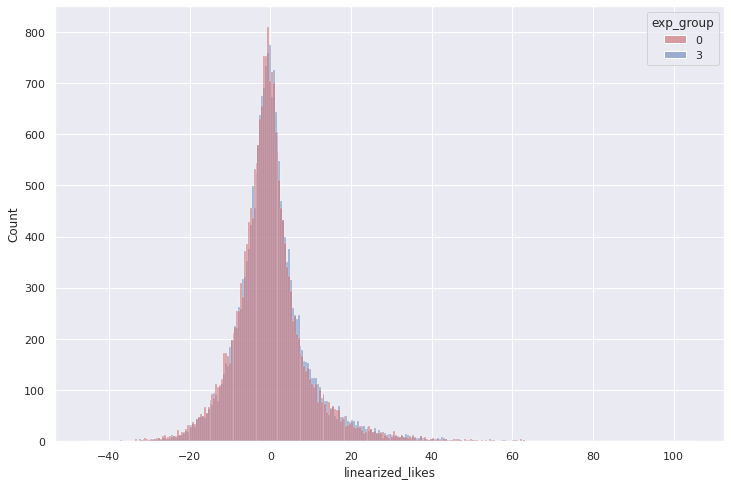

In [37]:
# Отобразим распредления линеаризованных лайков по группам
sns.set(rc={'figure.figsize': [12.0, 8.0]})
sns.histplot(data=df,
             x = 'linearized_likes',
             hue = 'exp_group',
             palette = ['r','b'],
             alpha = 0.5,
             kde = False)

Распределения похожи друг на друга и близки к нормальному

**Гипотеза:** линеаризованные лайки внутри групп 0 и 3 разные<br>
**Нулевая гипотеза:** линеаризованные лайки внутри групп равны<br>
**Альтернативная гипотеза:** линеаризованные лайки внутри групп отличаются<br>
**Пороговое значение p-value:** 0.05

In [43]:
# Параметрчиеский t-тест
p_value11 = stats.ttest_ind(df[df.exp_group == 0].linearized_likes,
                df[df.exp_group == 3].linearized_likes,
                equal_var = False,
                alternative = 'two-sided')[1]
print('Отличие не покрасилось, p_value = ' + str(p_value11) if p_value > 0.05
      else 'Отличие покрасилось, p_value = ' + str(p_value11))

Отличие покрасилось, p_value = 1.8016389997239062e-07


In [47]:
# Непараметрический тест Манна-Уитни
p_value12 = stats.mannwhitneyu(df[df.exp_group == 0].linearized_likes,
                   df[df.exp_group == 3].linearized_likes,
                   alternative='two-sided')[1]
print('Отличие не покрасилось, p_value = ' + str(p_value12) if p_value > 0.05
      else 'Отличие покрасилось, p_value = ' + str(p_value12))

Отличие покрасилось, p_value = 7.149855166577329e-10


Тесты показали, что статистически значимой разницы между группами нет - они одинаковы

In [57]:
# Сравним p_value у обычного пользовательского ctr и линеаризованных лайков

print('p_value после t-теста стало меньше в ' + str(p_value01 / p_value11) + ' раз')
print('p_value после теста Манна-Уитни стало больше в ' + str(p_value12 / p_value02) + ' раз')

p_value после t-теста стало меньше в 11.880406406585939 раз
p_value после теста Манна-Уитни стало больше в 2.4587666858250303 раз


## Аналогичные исследования для 1 и 2 группы

In [58]:
# Создаем dataframe
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2023-01-31' and toDate(time) <= '2023-02-26' 
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection = connection)

df.head()

,exp_group,user_id,likes,views,ctr
0,1,140764,13,52,0.250000
1,1,49204,10,62,0.161290
2,1,145957,72,171,0.421053
3,1,18392,20,100,0.200000
4,2,131473,38,231,0.164502


<AxesSubplot:xlabel='ctr', ylabel='Count'>

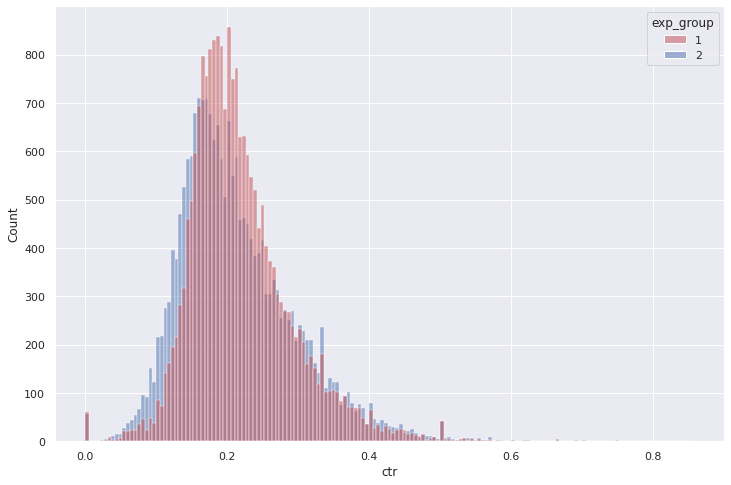

In [59]:
# Построим распредление гурпп 1 и 2
sns.set(rc={'figure.figsize': [12.0, 8.0]})
sns.histplot(data=df,
             x = 'ctr',
             hue = 'exp_group',
             palette=['r','b'],
             alpha = 0.5,
             kde = False)

**Гипотеза:** CTR внутри групп 1 и 2 разные<br>
**Нулевая гипотеза:** CTR внутри групп равны<br>
**Альтернативная гипотеза:** CTR внутри групп отличаются<br>
**Пороговое значение p-value:** 0.05

In [62]:
# Проведем параметрический t-тест
p_value01 = stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False,
                alternative='two-sided')[1]
print('Отличие не покрасилось, p_value = ' + str(p_value01) if p_value > 0.05
      else 'Отличие покрасилось, p_value = ' + str(p_value01))

Отличие покрасилось, p_value = 9.30684877586138e-11


In [63]:
# Проведем непараметрический тест Манна-Уитни
p_value02 = stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                               df[df.exp_group == 2].ctr,
                               alternative='two-sided')[1]
print('Отличие не покрасилось, p_value = ' + str(p_value02) if p_value > 0.05
      else 'Отличие покрасилось, p_value = ' + str(p_value02))

Отличие покрасилось, p_value = 4.050569527699207e-35


Тесты показали, что статистически значимой разницы между группами нет - они одинаковы

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

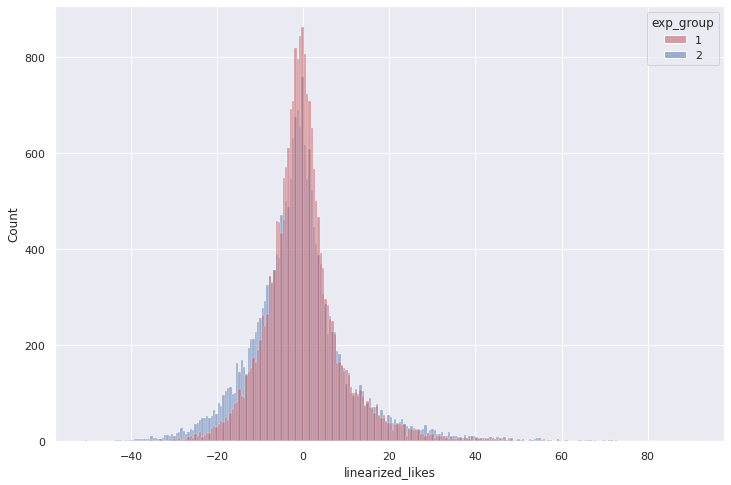

In [65]:
# Считаем общий CTR в контрольной группе
ctr_control = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()

# Посчитаем в обеих группах поюзерную метрику
df['linearized_likes'] = df.likes - ctr_control * df.views

# Отобразим распредления линеаризованных лайков по группам
sns.set(rc={'figure.figsize': [12.0, 8.0]})
sns.histplot(data=df,
             x = 'linearized_likes',
             hue = 'exp_group',
             palette = ['r','b'],
             alpha = 0.5,
             kde = False)

**Гипотеза:** линеаризованные лайки внутри групп 1 и 2 разные<br>
**Нулевая гипотеза:** линеаризованные лайки внутри групп равны<br>
**Альтернативная гипотеза:** линеаризованные лайки внутри групп отличаются<br>
**Пороговое значение p-value:** 0.05

In [67]:
# Параметрчиеский t-тест
p_value11 = stats.ttest_ind(df[df.exp_group == 1].linearized_likes,
                df[df.exp_group == 2].linearized_likes,
                equal_var = False,
                alternative = 'two-sided')[1]
print('Отличие не покрасилось, p_value = ' + str(p_value11) if p_value > 0.05
      else 'Отличие покрасилось, p_value = ' + str(p_value11))

Отличие покрасилось, p_value = 2.176974475648723e-16


In [68]:
# Непараметрический тест Манна-Уитни
p_value12 = stats.mannwhitneyu(df[df.exp_group == 1].linearized_likes,
                   df[df.exp_group == 2].linearized_likes,
                   alternative='two-sided')[1]
print('Отличие не покрасилось, p_value = ' + str(p_value12) if p_value > 0.05
      else 'Отличие покрасилось, p_value = ' + str(p_value12))

Отличие покрасилось, p_value = 2.79747250668264e-25


Тесты показали, что статистически значимой разницы между группами нет - они одинаковы

In [71]:
# Сравним p_value у обычного пользовательского ctr и линеаризованных лайков

print('p_value после t-теста стало меньше в ' + str(p_value01 / p_value11) + ' раз')
print('p_value после теста Манна-Уитни стало больше в ' + str(p_value12 / p_value02) + ' раз')

p_value после t-теста стало меньше в 427512.99475332635 раз
p_value после теста Манна-Уитни стало больше в 6906368320.683171 раз


## Вывод:

Метод линеаризованных лайков повысил чувствительность t-теста в разы: p_value действительно уменьшалось, однако чувствительность теста Манна-Уитни была ухудшена